<a href="https://www.kaggle.com/ranchanakiriyapong/covid-normal-viral-pneumonia-image-classification?scriptVersionId=88824565" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-859.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-158.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-10121.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-1811.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-97.png
/kaggle/input/covid19-radiography-database/COVID-19_Radi

This classification model was trained and validated on 3,328 images and 807 images, respectively. As there was imbalance of database provided, sampling was based on the least number of class's images.

# Import Libraries

In [2]:
# libraries for files preparation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil

# libraries for CNN models and plotting
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline


# Data Sampling

In [3]:
# install openpyxl to read excel files
!pip install openpyxl

     |████████████████████████████████| 242 kB 884 kB/s            


In [4]:
covid = pd.read_excel('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
covid.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [5]:
normal = pd.read_excel('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
normal.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [6]:
viral_pneumonia = pd.read_excel('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx')
viral_pneumonia.head()

,FILE NAME,FORMAT,SIZE,URL
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
2,Viral Pneumonia-3,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
3,Viral Pneumonia-4,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
4,Viral Pneumonia-5,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


In [7]:
# Check the numbers of each cases
print("Covid cases: ", str(len(covid)))
print("Normal cases: ", str(len(normal)))
print("Viral Pneumonia cases: ", str(len(viral_pneumonia)))

Covid cases:  3616
Normal cases:  10192
Viral Pneumonia cases:  1345


The least number of each class is 1345. Therefore, set the sample size to 1345 samples.

In [8]:
SAMPLE_SIZE = 1345

In [9]:
# add label for each case
covid['label'] = 0
normal['label'] = 1
viral_pneumonia['label'] = 2

In [10]:
# drop non-related columns
covid = covid[['FILE NAME', 'label']]
normal = normal[['FILE NAME', 'label']]
viral_pneumonia = viral_pneumonia[['FILE NAME', 'label']]

In [11]:
# take a look to covid dataframe
covid.head()

,FILE NAME,label
0,COVID-1,0
1,COVID-2,0
2,COVID-3,0
3,COVID-4,0
4,COVID-5,0


In [12]:
# sampling data for covid and normal cases
df_0 = covid.sample(SAMPLE_SIZE, random_state=26)
df_1 = normal.sample(SAMPLE_SIZE, random_state=26)

# concat dataframes
data = pd.concat([df_0, df_1, viral_pneumonia], axis=0).reset_index(drop=True)

# check numbers of each label
data['label'].value_counts()

0    1345
1    1345
2    1345
Name: label, dtype: int64

In [13]:
# shuffle data
data = shuffle(data)
data.head()

,FILE NAME,label
1445,NORMAL-2759,1
1157,COVID-2300,0
3597,Viral Pneumonia-908,2
2894,Viral Pneumonia-205,2
506,COVID-2611,0


## Train Test Split

In [14]:
df_train, df_val = train_test_split(data, test_size=0.20, random_state=26, stratify=data['label'])

print(df_train.shape)
print(df_val.shape)

(3228, 2)
(807, 2)


In [15]:
df_train['label'].value_counts()

1    1076
2    1076
0    1076
Name: label, dtype: int64

In [16]:
df_val['label'].value_counts()

1    269
2    269
0    269
Name: label, dtype: int64

## Creating Directories

In [17]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


# create 2 folders inside 'base_dir':
# base_dir
  ## train_dir
     ### covid
     ### normal
     ### viral_pneumonia
  ## val_dir
     ### covid
     ### normal
     ### viral_pneumonia

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
train_covid = os.path.join(train_dir, 'covid')
os.mkdir(train_covid)
train_normal = os.path.join(train_dir, 'normal')
os.mkdir(train_normal)
train_viral_pneumonia = os.path.join(train_dir, 'viral pneumonia')
os.mkdir(train_viral_pneumonia)

# create new folders inside val_dir
val_covid = os.path.join(val_dir, 'covid')
os.mkdir(val_covid)
val_normal = os.path.join(val_dir, 'normal')
os.mkdir(val_normal)
val_viral_pneumonia = os.path.join(val_dir, 'viral pneumonia')
os.mkdir(val_viral_pneumonia)

In [18]:
# check the folders in train_dir
os.listdir('base_dir/train_dir')

['viral pneumonia', 'covid', 'normal']

## Transfer Images into Folders

In [19]:
train_list = list(df_train['FILE NAME'])
val_list = list(df_val['FILE NAME'])


In [20]:
# Copy images to train_dir folder
for image in train_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID', filename)
        
    if target == 1:
        label = 'normal'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        filename = filename.capitalize()
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal', filename)
        
    if target == 2:
        label = 'viral pneumonia'
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia', filename)
  
    # destination path to image
    dst = os.path.join(train_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Copy images to val_dir folder
for image in val_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID', filename)
        
    if target == 1:
        label = 'normal'
        filename = filename.capitalize()
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal', filename)
        
    if target == 2:
        label = 'viral pneumonia'
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia', filename)
  
    # destination path to image
    dst = os.path.join(val_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [21]:
# check the number of train images in each folder
print(len(os.listdir('base_dir/train_dir/covid')))
print(len(os.listdir('base_dir/train_dir/normal')))
print(len(os.listdir('base_dir/train_dir/viral pneumonia')))

1076
1076
1076


In [22]:
# check the number of validation images in each folder
print(len(os.listdir('base_dir/val_dir/covid')))
print(len(os.listdir('base_dir/val_dir/normal')))
print(len(os.listdir('base_dir/val_dir/viral pneumonia')))

269
269
269


==================== End of Files Preparation ====================

# Image Classification

In [23]:
BATCH_SIZE = 32
IMG_SIZE = (256  , 256)
train_directory = "base_dir/train_dir"
val_directory = "base_dir/val_dir"
                                  

## Generate Train/Val Dataset

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=0.2,
        shear_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_directory,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 3228 images belonging to 3 classes.
Found 807 images belonging to 3 classes.


In [25]:
# check classes in train_generator
train_generator.class_indices

{'covid': 0, 'normal': 1, 'viral pneumonia': 2}

Take a look to some of samples in `train_generator`

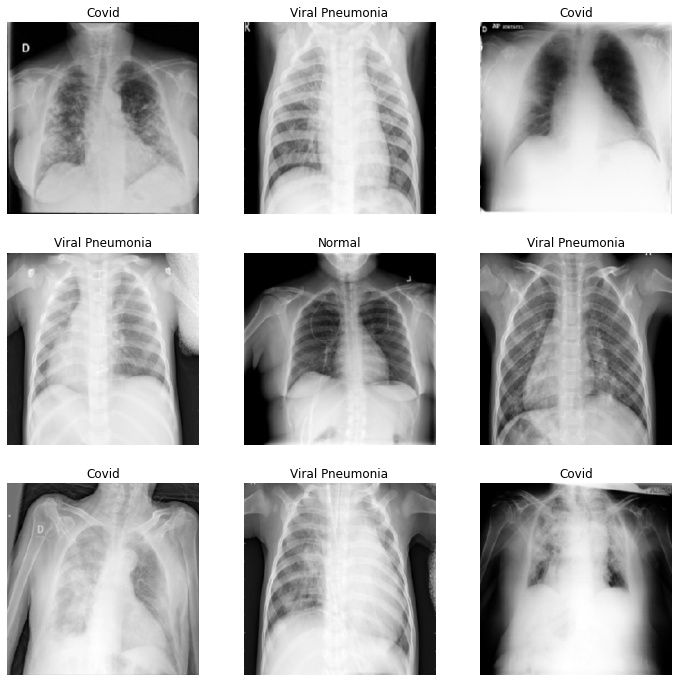

In [26]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = train_generator.next()
    plt.imshow(img[0], cmap='gray')
    dic = {0:'Covid', 1:'Normal', 2:'Viral Pneumonia'}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

## Model Fitting
The model architecture is based on VGG-16 model, including 3x3 filter for convolutions layer and 2x2 filter for pooling layers, doubling the number of filters and three fully-connected layers.

In [27]:
def covid_model1(IMG_SIZE):
    input_shape = IMG_SIZE + (1, )
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding='same',input_shape=input_shape),
        MaxPooling2D(pool_size = (2, 2)), 
        Conv2D(32, (3, 3), padding='same', activation="relu"),
        MaxPooling2D(pool_size = (2, 2)), 
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(256, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
       
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=3, activation='softmax')
    ])
    return model

In [28]:
# recheck the image size
IMG_SIZE

(256, 256)

In [29]:
model1 = covid_model1(IMG_SIZE)

2022-02-26 23:37:50.852668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 23:37:50.966361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 23:37:50.967102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 23:37:50.968972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        3

In [31]:
base_learning_rate = 0.001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [33]:
initial_epochs = 15
history = model1.fit(train_generator, epochs=initial_epochs, 
                     validation_data = validation_generator, callbacks=[early_stopping])

2022-02-26 23:37:54.346699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-02-26 23:37:56.396144: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


101/101 [==============================] - 31s 229ms/step - loss: 0.8361 - accuracy: 0.5558 - val_loss: 0.5494 - val_accuracy: 0.7658
Epoch 2/15
101/101 [==============================] - 23s 230ms/step - loss: 0.5507 - accuracy: 0.7581 - val_loss: 0.5906 - val_accuracy: 0.7732
Epoch 3/15
101/101 [==============================] - 23s 231ms/step - loss: 0.5177 - accuracy: 0.7742 - val_loss: 0.4708 - val_accuracy: 0.8017
Epoch 4/15
101/101 [==============================] - 23s 226ms/step - loss: 0.4701 - accuracy: 0.7968 - val_loss: 0.4929 - val_accuracy: 0.7881
Epoch 5/15
101/101 [==============================] - 23s 229ms/step - loss: 0.4141 - accuracy: 0.8188 - val_loss: 0.4631 - val_accuracy: 0.8129
Epoch 6/15
101/101 [==============================] - 24s 241ms/step - loss: 0.3615 - accuracy: 0.8541 - val_loss: 0.3431 - val_accuracy: 0.8575
Epoch 7/15
101/101 [==============================] - 23s 232ms/step - loss: 0.3132 - accuracy: 0.8696 - val_loss: 0.3179 - val_accuracy: 0.8

## Model Evaluation

In [34]:
# Evaluate the model by getting its final loss and accuracy
model1.evaluate(validation_generator)

26/26 [==============================] - 2s 90ms/step - loss: 0.2149 - accuracy: 0.9207


[0.21492411196231842, 0.9206939339637756]

In [35]:
# create history loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_loss))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, color='b', label='Train')
    plt.plot(epochs, val_loss, color='r', label='Validation')
    plt.legend()
    plt.title('Model Loss')
    
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, color='b', label='Train')
    plt.plot(epochs, val_acc, color='r', label='Validation')
    plt.legend()
    plt.title('Model Accuracy')
    
    plt.show()

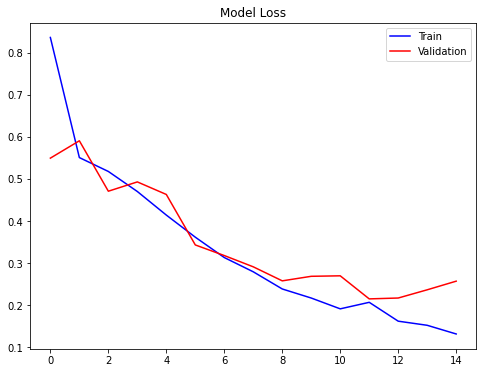

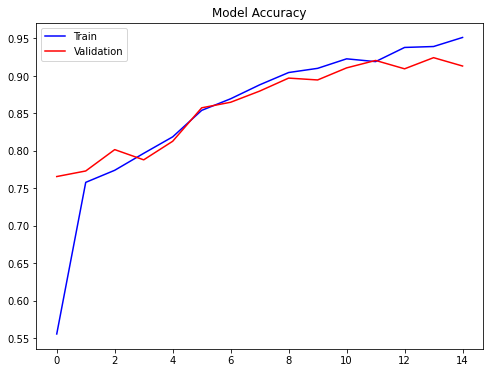

In [36]:
plot_loss_acc(history)

## ClassificaitonConfusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [38]:
# predict classes of validation dataset
val_predict = model1.predict(validation_generator)

In [39]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [40]:
labels = ['Covid', 'Normal', 'Viral Pneumonia']
report = classification_report(validation_generator.classes, predict_class, target_names=labels)
print(report)

                 precision    recall  f1-score   support

          Covid       0.91      0.89      0.90       269
         Normal       0.87      0.93      0.90       269
Viral Pneumonia       0.98      0.94      0.96       269

       accuracy                           0.92       807
      macro avg       0.92      0.92      0.92       807
   weighted avg       0.92      0.92      0.92       807



In [41]:
cm = confusion_matrix(validation_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL','VIRAL PNEUMONIA'], 
                     columns = ['COVID','NORMAL','VIRAL PNEUMONIA'])

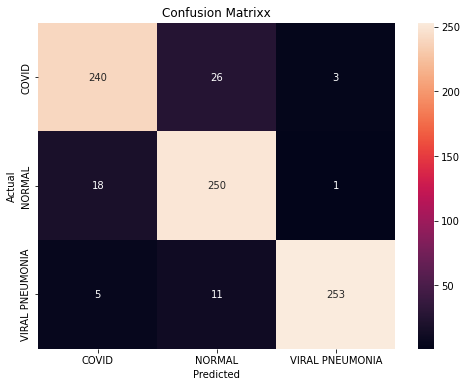

In [42]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Summary
- The model has train accuracy at 89% and validation accuracy at 90%. The model can be improved its architecture or trained with more data to increase its efficiency. 
- The confusion matrix shows that the model predicted well on Viral Pneumonia images. However, there were still many cases of normal predicted to covid or vice versa.

# References
1. [CNN - How to use 160,000 images without crashing](https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing)
2. [Medical X-ray ⚕️ Image Classification using Convolutional Neural Network](https://medium.com/towards-data-science/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a)